In [1]:
%matplotlib inline
from torch import optim, nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import torch
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing

In [158]:
class FeedForwardNet(nn.Module):
    """ Simple feed forward network with three hidden layers."""
    def __init__(self): # initialize the model
        super(FeedForwardNet, self).__init__() # call for the parent class to initialize
        # Nfeatures stands for the number of features that each galaxy
        # provides, e.g. its (g-r) color inside or outside the fiber,
        # magnitude in various bands, etc. 
        # Nfeatures should be adjusted if the number of galaxy features
        # changes. Otherwise FeedForwardNet will break.
        self.Nfeatures = 20
        
        # Noutcomes is the size of the output vector. Since we are
        # only calulate the SFR, Noutcomes is 1.
        self.Noutcomes = 1
        # Nsamples is the size of the packet of galaxies used in a single batch.
        self.Nsamples = 50
        weight1_shape = [self.Nfeatures, self.Nsamples]
        weight2_shape = [self.Nsamples, 2000]
        weight3_shape = [2000, 2000]
        weight4_shape = [2000, 2000]
        weight5_shape = [2000, 2000]
        weight6_shape = [2000, 2000]
        weight7_shape = [2000, 50]
        weight8_shape = [50, self.Noutcomes]


        self.W1 = nn.Linear(*weight1_shape)
        self.W2 = nn.Linear(*weight2_shape)
        self.W3 = nn.Linear(*weight3_shape)
        self.W4 = nn.Linear(*weight4_shape)
        self.W5 = nn.Linear(*weight5_shape)
        self.W6 = nn.Linear(*weight6_shape)
        self.W7 = nn.Linear(*weight7_shape)
        self.W8 = nn.Linear(*weight8_shape)


    def forward(self, x):
        """
        this is the function that will be executed when we call the logistic regression on data.
        INPUT:
            x, a photometric data vector represented as a tensor of shape 27
        OUTPUT:
            forward_result, a tensor of shape 1
        """
        activation_fn = nn.PReLU()

        forward_result = self.W1(x)
        layernormer    = nn.LayerNorm(forward_result.size())
        forward_result = layernormer(forward_result)
        forward_result = activation_fn(forward_result)

        forward_result = self.W2(forward_result)
        layernormer    = nn.LayerNorm(forward_result.size())
        forward_result = layernormer(forward_result)
        forward_result = activation_fn(forward_result)

        forward_result = self.W3(forward_result)
        layernormer    = nn.LayerNorm(forward_result.size())
        forward_result = layernormer(forward_result)
        forward_result = activation_fn(forward_result)
        
        forward_result = self.W4(forward_result)
        layernormer    = nn.LayerNorm(forward_result.size())
        forward_result = layernormer(forward_result)
        forward_result = activation_fn(forward_result)
        
        forward_result = self.W5(forward_result)
        layernormer    = nn.LayerNorm(forward_result.size())
        forward_result = layernormer(forward_result)
        forward_result = activation_fn(forward_result)
        
        forward_result = self.W6(forward_result)
        layernormer    = nn.LayerNorm(forward_result.size())
        forward_result = layernormer(forward_result)
        forward_result = activation_fn(forward_result)
        
        forward_result = self.W7(forward_result)
        forward_result = activation_fn(forward_result)

        forward_result = self.W8(forward_result)

        forward_result = torch.reshape(forward_result, [self.Nsamples, self.Noutcomes])

        return forward_result

def train(model,loss_fn, optimizer, train_loader, test_loader):
    """
    This is a standard training loop, which leaves some parts to be filled in.
    INPUT:
    :param model: an untrained pytorch model (instance of a neural network)
    :param loss_fn: e.g. Cross Entropy loss of Mean Squared Error.
    :param optimizer: the model optimizer, initialized with a learning rate.
    :param training_set: The training data, in a dataloader for easy iteration.
    :param test_loader: The testing data, in a dataloader for easy iteration.
    """
    # num_epochs defines the number of times that the model repeats its training.
    # Higher num_epochs does not necessarily mean a better fit, as it is possible
    # to over-train the neural network and result in the NN "memorizing" the training set
    # (also known as overfitting).
    # To safe-guard against this, we include a regularization term below
    num_epochs = 7
    
    for epoch in range(num_epochs):
        # loop through each data point in the training set
        for data, targets in train_loader:
            # run the model on the data
            Nsample = len(targets)
            Nfeatures = len(data.T)
            model_input = torch.reshape(data, (Nsample, Nfeatures))
            model_output = model(model_input)
            
            # Check for Nan and infinity numbers in the output, as NaN and inf
            # break the neural net when one feeds model_output to the loss function
            if torch.isnan(sum(sum(model_output))) or torch.isinf(sum(sum(model_output))):
                print("sum(sum(model_input))", sum(sum(model_input)))
                print(model_input)
                print("sum(sum(model_output))", sum(sum(model_output)))
                print('invalid input detected at iteration ', epoch)
            
            # Evaluate the quality of model_output by calculating the loss function
            loss = loss_fn(model_output, targets) 
            
            #--------REGULARIZATION:--------
            # Add an L2 regularization term to the loss to alleviate the effects of overfitting
            l2_lambda=0.005
            for name, param in model.named_parameters():
                if "weight" in name:
                    loss += 0.5 * l2_lambda* (param ** 2).sum()/len(data)
            # Find the gradients of our loss via backpropogation
            loss.backward()

            # Adjust accordingly with the optimizer
            optimizer.step()
            optimizer.zero_grad()
            
        print("loss", loss.item())
        # Give status reports every 50 epochs
        if epoch % 1==0:
            print("Evaluating results on the training dataset")
            evaluate_train = np.round(evaluate(model,train_loader, loss_fn,  Nsample=Nsample), 4)
            print("Evaluating results on the test dataset")
            evaluate_test = np.round(evaluate(model,test_loader,loss_fn,  Nsample=Nsample), 4)

            dataseries = pd.Series({"epoch":int(epoch),
                                    "Train accuracy": evaluate_train,
                                    "Test accuracy": evaluate_test,
                                    "Loss" : np.round(loss.item(), 4)})
            print("train loss", evaluate_train)
            print("test loss", evaluate_test)
                                   




def evaluate(model, evaluation_set, loss_fn, Nsample=50, Nfeatures=20):
    """
    Evaluates the given model on the given dataset.
    Returns the percentage of correct classifications out of total classifications.
    """
    accuracy = 0
    output_almanach = np.array([])
    check_collection = np.array([])
    with torch.no_grad(): # this disables backpropogation, which makes the model run much more quickly.
        for data, targets in evaluation_set:
            try:
                model_input = torch.reshape(data, [Nsample, Nfeatures])
            except RuntimeError as e:
                print(e)
                continue
            output = model(model_input)
            if np.random.rand()<0.25:
                accuracy = loss_fn(output, targets)
            output_almanach = np.hstack([output_almanach, output.detach().numpy().flatten()])
            check_collection = np.hstack([check_collection, targets.detach().numpy().flatten()])

    fig, axes = plt.subplots(figsize=(4,3), dpi=150)
    unscaled_output = output_almanach*(minmaxes['SFR']['max']-
                                       minmaxes['SFR']['min'])+minmaxes['SFR']['min']
    unscaled_input = check_collection*(minmaxes['SFR']['max']-
                                       minmaxes['SFR']['min'])+minmaxes['SFR']['min']

    scat = plt.scatter( unscaled_output, unscaled_input, alpha=0.5)
    axes.plot([-1.75, -0.4], [-1.75, -0.4], c='grey')
    axes.set(xlabel='Predicted  log SFR', ylabel='GSWLC log SFR')
    fig.canvas.draw()
    plt.show()
    return accuracy



### Read in training data

In [230]:
sdss_photo_data = np.load("photometric_data_with_z.npy")
ground_truth_sfrs = np.load("sfr_data_synced_to_photo_dictionary_with_z.npy")
saga_photo_data = np.load("SAGA_sats_photometric_data.npy")
absmagdata = np.load("absolute_photometric_data_with_z.npy")

In [231]:
# Turn the input photometric data into a pandas DataFrame with the corresponding column names

photodf = pd.DataFrame(sdss_photo_data, columns=['fiber_g_mag', 'full_g_mag',
                                        'fiber_r_mag', 'full_r_mag',
                                        'fiber_z_mag', 'full_z_mag',
                                        'fiber_nuv_mag', 'full_nuv_mag',
                                        'fiber_fuv_mag', 'full_fuv_mag',
                                        'g_r_fiber', 'g_r_full',
                                        'r_z_fiber', 'r_z_full',
                                        'fuv_nuv_fiber', 'fuv_nuv_full','rband', 'z','halpha_pos', 'halpha_neg'])
absmagphotodf = pd.DataFrame(absmagdata, columns=['fiber_g_mag', 'full_g_mag',
                                        'fiber_r_mag', 'full_r_mag',
                                        'fiber_z_mag', 'full_z_mag',
                                        'fiber_nuv_mag', 'full_nuv_mag',
                                        'fiber_fuv_mag', 'full_fuv_mag',
                                        'g_r_fiber', 'g_r_full',
                                        'r_z_fiber', 'r_z_full',
                                        'fuv_nuv_fiber', 'fuv_nuv_full','rband', 'z','halpha_pos', 'halpha_neg'
                                                 , 'SFR'])
saga_df = pd.DataFrame(saga_photo_data, columns=['fiber_g_mag', 'full_g_mag',
                                        'fiber_r_mag', 'full_r_mag',
                                        'fiber_z_mag', 'full_z_mag',
                                        'fiber_nuv_mag', 'full_nuv_mag',
                                        'fiber_fuv_mag', 'full_fuv_mag',
                                        'g_r_fiber', 'g_r_full',
                                        'r_z_fiber', 'r_z_full',
                                        'fuv_nuv_fiber', 'fuv_nuv_full', 'rband', 'z', 'halpha_pos', 'halpha_neg'])
print(np.unique(saga_df['halpha_neg']))

[-9.9000e+01 -2.3907e+00 -2.0000e+00 -1.5108e+00 -1.4340e+00 -1.3229e+00
 -1.2270e+00 -1.0716e+00 -1.0000e+00 -7.2220e-01  1.0000e-22]


In [237]:
# Take and store a log value of H-alpha for optimal model training
photodf['halpha_pos'] = np.log10(photodf['halpha_pos'].values)
photodf['halpha_neg'] = np.log10(abs(photodf['halpha_neg'].values))
saga_df['halpha_pos'] = np.log10(saga_df['halpha_pos'].values)
saga_df['halpha_neg'] = np.log10(abs(saga_df['halpha_neg'].values))
# Add the star formation rate column temporarily while we go through data cleaning
photodf['SFR'] = ground_truth_sfrs

# Take a look to make sure there are no surprises
photodf

/opt/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


,fiber_g_mag,full_g_mag,fiber_r_mag,full_r_mag,fiber_z_mag,full_z_mag,fiber_nuv_mag,full_nuv_mag,fiber_fuv_mag,full_fuv_mag,...,g_r_full,r_z_fiber,r_z_full,fuv_nuv_fiber,fuv_nuv_full,rband,z,halpha_pos,halpha_neg,SFR
0,19.875634,20.527209,19.280281,19.929611,18.961168,19.625306,21.952400,22.795154,23.650975,24.351031,...,1.246928,0.319113,0.304305,1.698575,1.555877,-16.589527,0.021350,1.588927,-22.0,-1.084
1,19.575449,20.604011,18.700386,19.727749,18.031472,19.018479,23.255323,24.584720,24.544293,25.635837,...,1.903625,0.668914,0.709270,1.288970,1.051118,-16.561733,0.021049,1.192162,-22.0,-1.274
2,18.656964,18.901711,18.192876,18.459833,17.906833,18.196509,21.160206,21.519196,22.860684,23.206856,...,0.708835,0.286043,0.263324,1.700478,1.687660,-16.675308,0.011782,2.323727,-22.0,-1.056
3,19.250799,20.400557,18.499912,19.615961,17.940470,19.023605,22.548661,24.102551,24.479397,26.046618,...,1.900646,0.559442,0.592356,1.930735,1.944067,-17.359554,0.025707,1.261685,-22.0,-0.829
4,20.384443,20.686785,19.634529,19.928174,19.100941,19.382613,23.131709,23.557883,24.291668,24.639711,...,1.052256,0.533588,0.545561,1.159958,1.081828,-17.135136,0.026598,0.969241,-22.0,-0.962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4267,19.761693,19.500531,18.876803,18.642642,18.482326,18.243521,23.103041,22.817330,25.252348,24.990101,...,0.623728,0.394477,0.399120,2.149307,2.172771,-16.170902,0.010900,-0.318267,-22.0,-1.967
4268,19.031822,18.529316,18.341400,17.844406,17.911094,17.423245,20.350225,19.748008,21.894388,21.272551,...,0.187917,0.430305,0.421161,1.544163,1.524543,-17.144087,0.010807,1.074613,-22.0,-0.505
4269,18.500518,17.805469,17.928156,17.275521,17.771039,17.075005,19.576613,18.676154,21.096564,20.231049,...,-0.122687,0.157116,0.200516,1.519952,1.554894,-17.322712,0.010634,2.465410,-22.0,-0.153
4270,19.444015,18.374819,18.768858,17.740579,18.394568,17.427237,20.966527,19.704082,22.660938,21.291699,...,-0.394039,0.374289,0.313342,1.694411,1.587617,-17.432831,0.012789,0.743450,-22.0,-1.222


[Text(0.5, 0, 'r band'), Text(0, 0.5, 'SFR')]

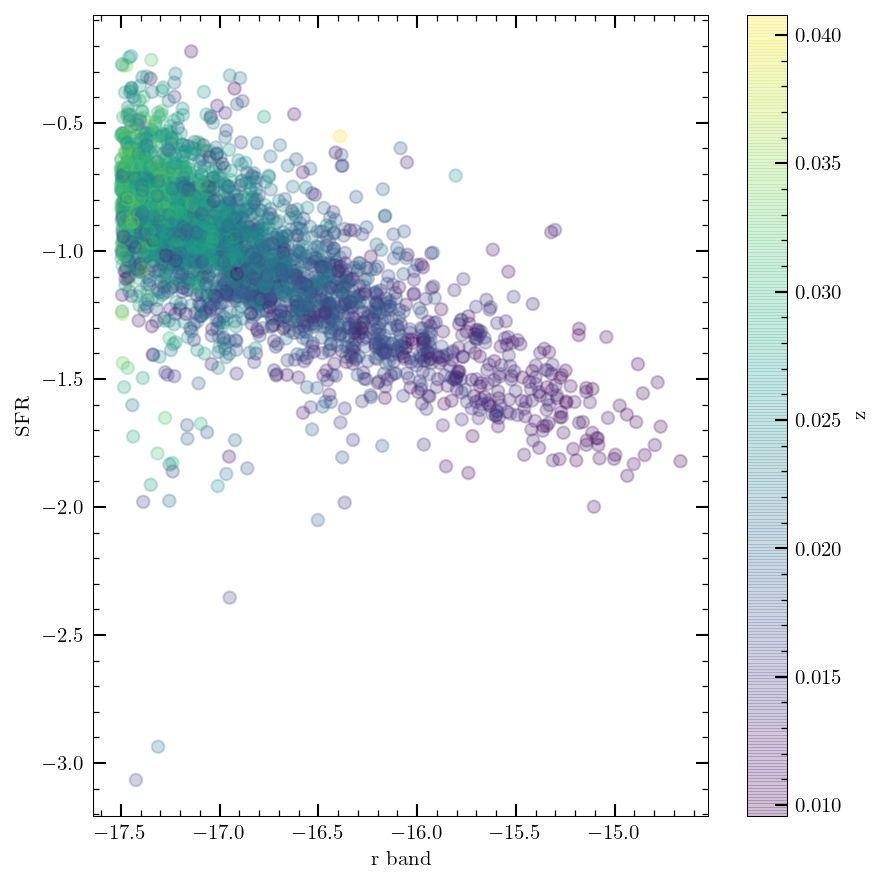

In [146]:
fig, axes = plt.subplots(figsize=(6,6), dpi=150)
scat = plt.scatter(cleaned_photodf['rband'], 
                                            cleaned_SFR, 
                   alpha=0.25, c=cleaned_photodf['z'].values)
cbar = plt.colorbar(scat)
cbar.ax.set_ylabel("z")
axes.set(xlabel="r band", ylabel="SFR")

## Clean training data

In [241]:
# Replace instances of infinity in the DataFrame with Nan, and then drop any rows
# that contain NaN entries:
cleaned_photodf = photodf.replace([np.inf, -np.inf, 1000], np.nan).dropna(axis=0)
cleaned_photodf

,fiber_g_mag,full_g_mag,fiber_r_mag,full_r_mag,fiber_z_mag,full_z_mag,fiber_nuv_mag,full_nuv_mag,fiber_fuv_mag,full_fuv_mag,...,g_r_full,r_z_fiber,r_z_full,fuv_nuv_fiber,fuv_nuv_full,rband,z,halpha_pos,halpha_neg,SFR
0,19.875634,20.527209,19.280281,19.929611,18.961168,19.625306,21.952400,22.795154,23.650975,24.351031,...,1.246928,0.319113,0.304305,1.698575,1.555877,-16.589527,0.021350,1.588927,-22.0,-1.084
1,19.575449,20.604011,18.700386,19.727749,18.031472,19.018479,23.255323,24.584720,24.544293,25.635837,...,1.903625,0.668914,0.709270,1.288970,1.051118,-16.561733,0.021049,1.192162,-22.0,-1.274
2,18.656964,18.901711,18.192876,18.459833,17.906833,18.196509,21.160206,21.519196,22.860684,23.206856,...,0.708835,0.286043,0.263324,1.700478,1.687660,-16.675308,0.011782,2.323727,-22.0,-1.056
3,19.250799,20.400557,18.499912,19.615961,17.940470,19.023605,22.548661,24.102551,24.479397,26.046618,...,1.900646,0.559442,0.592356,1.930735,1.944067,-17.359554,0.025707,1.261685,-22.0,-0.829
4,20.384443,20.686785,19.634529,19.928174,19.100941,19.382613,23.131709,23.557883,24.291668,24.639711,...,1.052256,0.533588,0.545561,1.159958,1.081828,-17.135136,0.026598,0.969241,-22.0,-0.962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4267,19.761693,19.500531,18.876803,18.642642,18.482326,18.243521,23.103041,22.817330,25.252348,24.990101,...,0.623728,0.394477,0.399120,2.149307,2.172771,-16.170902,0.010900,-0.318267,-22.0,-1.967
4268,19.031822,18.529316,18.341400,17.844406,17.911094,17.423245,20.350225,19.748008,21.894388,21.272551,...,0.187917,0.430305,0.421161,1.544163,1.524543,-17.144087,0.010807,1.074613,-22.0,-0.505
4269,18.500518,17.805469,17.928156,17.275521,17.771039,17.075005,19.576613,18.676154,21.096564,20.231049,...,-0.122687,0.157116,0.200516,1.519952,1.554894,-17.322712,0.010634,2.465410,-22.0,-0.153
4270,19.444015,18.374819,18.768858,17.740579,18.394568,17.427237,20.966527,19.704082,22.660938,21.291699,...,-0.394039,0.374289,0.313342,1.694411,1.587617,-17.432831,0.012789,0.743450,-22.0,-1.222


In [242]:
cleaned_absphotodf = absmagphotodf.replace([np.inf, -np.inf, 1000], np.nan).dropna(axis=0)
cleaned_absphotodf

,fiber_g_mag,full_g_mag,fiber_r_mag,full_r_mag,fiber_z_mag,full_z_mag,fiber_nuv_mag,full_nuv_mag,fiber_fuv_mag,full_fuv_mag,...,g_r_full,r_z_fiber,r_z_full,fuv_nuv_fiber,fuv_nuv_full,rband,z,halpha_pos,halpha_neg,SFR
0,-14.966860,-14.315285,-15.562213,-14.912884,-15.881327,-15.217189,-12.890094,-12.047341,-11.191520,-10.491464,...,1.246928,0.319113,0.304305,1.698575,1.555877,-16.589527,0.021350,1.588927,-22.0,-1.084
1,-15.235661,-14.207100,-16.110725,-15.083361,-16.779639,-15.792631,-11.555787,-10.226391,-10.266818,-9.175273,...,1.903625,0.668914,0.709270,1.288970,1.051118,-16.561733,0.021049,1.192162,-22.0,-1.274
2,-14.878956,-14.634209,-15.343044,-15.076087,-15.629087,-15.339412,-12.375714,-12.016724,-10.675236,-10.329064,...,0.708835,0.286043,0.263324,1.700478,1.687660,-16.675308,0.011782,2.323727,-22.0,-1.056
3,-16.002013,-14.852255,-16.752900,-15.636851,-17.312342,-16.229207,-12.704151,-11.150261,-10.773415,-9.206194,...,1.900646,0.559442,0.592356,1.930735,1.944067,-17.359554,0.025707,1.261685,-22.0,-0.829
4,-14.943842,-14.641500,-15.693756,-15.400111,-16.227344,-15.945672,-12.196575,-11.770401,-11.036617,-10.688573,...,1.052256,0.533588,0.545561,1.159958,1.081828,-17.135136,0.026598,0.969241,-22.0,-0.962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4267,-13.603778,-13.864940,-14.488668,-14.722829,-14.883145,-15.121950,-10.262430,-10.548141,-8.113123,-8.375370,...,0.623728,0.394477,0.399120,2.149307,2.172771,-16.170902,0.010900,-0.318267,-22.0,-1.967
4268,-14.314784,-14.817290,-15.005206,-15.502200,-15.435512,-15.923361,-12.996382,-13.598598,-11.452218,-12.074055,...,0.187917,0.430305,0.421161,1.544163,1.524543,-17.144087,0.010807,1.074613,-22.0,-0.505
4269,-14.810893,-15.505942,-15.383255,-16.035890,-15.540371,-16.236405,-13.734798,-14.635256,-12.214846,-13.080362,...,-0.122687,0.157116,0.200516,1.519952,1.554894,-17.322712,0.010634,2.465410,-22.0,-0.153
4270,-14.271671,-15.340867,-14.946829,-15.975107,-15.321118,-16.288449,-12.749159,-14.011604,-11.054748,-12.423987,...,-0.394039,0.374289,0.313342,1.694411,1.587617,-17.432831,0.012789,0.743450,-22.0,-1.222


In [243]:
saga_df

,fiber_g_mag,full_g_mag,fiber_r_mag,full_r_mag,fiber_z_mag,full_z_mag,fiber_nuv_mag,full_nuv_mag,fiber_fuv_mag,full_fuv_mag,g_r_fiber,g_r_full,r_z_fiber,r_z_full,fuv_nuv_fiber,fuv_nuv_full,rband,z,halpha_pos,halpha_neg
0,23.005058,21.521304,22.551156,21.055906,22.313914,20.852333,24.897453,23.280228,25.274381,23.783058,0.453902,-1.029853,0.237243,0.203573,0.376929,0.502830,-14.440759,0.008159,2.310151,-22.000000
1,18.088405,15.774047,16.708283,14.613272,15.470828,13.547104,21.404120,18.732575,22.965252,20.363587,1.380122,-0.934236,1.237455,1.066168,1.561132,1.631012,-19.755708,0.008110,-22.000000,1.995635
2,22.147913,22.961240,21.691144,22.475254,21.533170,22.283593,22.924802,23.802823,26.617582,1000.000000,0.456769,1.270096,0.157974,0.191661,3.692780,976.197177,-13.235816,0.008565,1.811132,-22.000000
3,21.090489,19.160439,20.533132,18.653711,20.366320,18.346020,23.333820,20.691254,24.530673,21.560656,0.557357,-1.372693,0.166812,0.307691,1.196853,0.869402,-15.944239,0.008134,0.764804,-22.000000
4,21.802125,19.737355,21.386456,19.326915,21.135119,19.117012,22.784920,20.797786,24.177231,22.132441,0.415669,-1.649102,0.251337,0.209903,1.392311,1.334655,-15.771720,0.008391,1.511927,-22.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,21.963280,19.677001,21.298944,19.219404,20.558951,18.867021,22.215865,19.887380,24.236337,21.409446,0.664336,-1.621943,0.739993,0.352383,2.020472,1.522066,-14.362570,0.008384,1.067592,-22.000000
122,21.737458,21.737458,21.533993,21.533993,21.518851,21.518851,22.717123,22.717123,24.225925,24.225925,0.203465,0.203465,0.015142,0.015142,1.508801,1.508801,-13.102480,0.007334,0.803266,-22.000000
123,21.978204,20.673719,21.598391,20.278567,21.412951,20.159235,22.304619,21.061481,23.642948,22.289820,0.379813,-0.924673,0.185441,0.119332,1.338329,1.228339,-15.057111,0.008804,1.161955,-22.000000
124,19.958441,18.240680,19.663501,17.938213,19.537474,17.811672,20.517872,18.647401,21.880762,19.967510,0.294940,-1.422821,0.126027,0.126541,1.362890,1.320109,-16.758266,0.008818,1.640569,-22.000000


In [244]:
cleaned_sagadf = saga_df.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
cleaned_sagadf

,fiber_g_mag,full_g_mag,fiber_r_mag,full_r_mag,fiber_z_mag,full_z_mag,fiber_nuv_mag,full_nuv_mag,fiber_fuv_mag,full_fuv_mag,g_r_fiber,g_r_full,r_z_fiber,r_z_full,fuv_nuv_fiber,fuv_nuv_full,rband,z,halpha_pos,halpha_neg
0,23.005058,21.521304,22.551156,21.055906,22.313914,20.852333,24.897453,23.280228,25.274381,23.783058,0.453902,-1.029853,0.237243,0.203573,0.376929,0.502830,-14.440759,0.008159,2.310151,-22.000000
1,18.088405,15.774047,16.708283,14.613272,15.470828,13.547104,21.404120,18.732575,22.965252,20.363587,1.380122,-0.934236,1.237455,1.066168,1.561132,1.631012,-19.755708,0.008110,-22.000000,1.995635
2,22.147913,22.961240,21.691144,22.475254,21.533170,22.283593,22.924802,23.802823,26.617582,1000.000000,0.456769,1.270096,0.157974,0.191661,3.692780,976.197177,-13.235816,0.008565,1.811132,-22.000000
3,21.090489,19.160439,20.533132,18.653711,20.366320,18.346020,23.333820,20.691254,24.530673,21.560656,0.557357,-1.372693,0.166812,0.307691,1.196853,0.869402,-15.944239,0.008134,0.764804,-22.000000
4,21.802125,19.737355,21.386456,19.326915,21.135119,19.117012,22.784920,20.797786,24.177231,22.132441,0.415669,-1.649102,0.251337,0.209903,1.392311,1.334655,-15.771720,0.008391,1.511927,-22.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,21.963280,19.677001,21.298944,19.219404,20.558951,18.867021,22.215865,19.887380,24.236337,21.409446,0.664336,-1.621943,0.739993,0.352383,2.020472,1.522066,-14.362570,0.008384,1.067592,-22.000000
122,21.737458,21.737458,21.533993,21.533993,21.518851,21.518851,22.717123,22.717123,24.225925,24.225925,0.203465,0.203465,0.015142,0.015142,1.508801,1.508801,-13.102480,0.007334,0.803266,-22.000000
123,21.978204,20.673719,21.598391,20.278567,21.412951,20.159235,22.304619,21.061481,23.642948,22.289820,0.379813,-0.924673,0.185441,0.119332,1.338329,1.228339,-15.057111,0.008804,1.161955,-22.000000
124,19.958441,18.240680,19.663501,17.938213,19.537474,17.811672,20.517872,18.647401,21.880762,19.967510,0.294940,-1.422821,0.126027,0.126541,1.362890,1.320109,-16.758266,0.008818,1.640569,-22.000000


In [245]:
# Now extract the SFR column back out
cleaned_SFR = cleaned_photodf['SFR'].values
cleaned_photodf = cleaned_photodf.drop(columns=['SFR'])
cleaned_photodf

,fiber_g_mag,full_g_mag,fiber_r_mag,full_r_mag,fiber_z_mag,full_z_mag,fiber_nuv_mag,full_nuv_mag,fiber_fuv_mag,full_fuv_mag,g_r_fiber,g_r_full,r_z_fiber,r_z_full,fuv_nuv_fiber,fuv_nuv_full,rband,z,halpha_pos,halpha_neg
0,19.875634,20.527209,19.280281,19.929611,18.961168,19.625306,21.952400,22.795154,23.650975,24.351031,0.595353,1.246928,0.319113,0.304305,1.698575,1.555877,-16.589527,0.021350,1.588927,-22.0
1,19.575449,20.604011,18.700386,19.727749,18.031472,19.018479,23.255323,24.584720,24.544293,25.635837,0.875064,1.903625,0.668914,0.709270,1.288970,1.051118,-16.561733,0.021049,1.192162,-22.0
2,18.656964,18.901711,18.192876,18.459833,17.906833,18.196509,21.160206,21.519196,22.860684,23.206856,0.464088,0.708835,0.286043,0.263324,1.700478,1.687660,-16.675308,0.011782,2.323727,-22.0
3,19.250799,20.400557,18.499912,19.615961,17.940470,19.023605,22.548661,24.102551,24.479397,26.046618,0.750887,1.900646,0.559442,0.592356,1.930735,1.944067,-17.359554,0.025707,1.261685,-22.0
4,20.384443,20.686785,19.634529,19.928174,19.100941,19.382613,23.131709,23.557883,24.291668,24.639711,0.749914,1.052256,0.533588,0.545561,1.159958,1.081828,-17.135136,0.026598,0.969241,-22.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4267,19.761693,19.500531,18.876803,18.642642,18.482326,18.243521,23.103041,22.817330,25.252348,24.990101,0.884890,0.623728,0.394477,0.399120,2.149307,2.172771,-16.170902,0.010900,-0.318267,-22.0
4268,19.031822,18.529316,18.341400,17.844406,17.911094,17.423245,20.350225,19.748008,21.894388,21.272551,0.690422,0.187917,0.430305,0.421161,1.544163,1.524543,-17.144087,0.010807,1.074613,-22.0
4269,18.500518,17.805469,17.928156,17.275521,17.771039,17.075005,19.576613,18.676154,21.096564,20.231049,0.572362,-0.122687,0.157116,0.200516,1.519952,1.554894,-17.322712,0.010634,2.465410,-22.0
4270,19.444015,18.374819,18.768858,17.740579,18.394568,17.427237,20.966527,19.704082,22.660938,21.291699,0.675158,-0.394039,0.374289,0.313342,1.694411,1.587617,-17.432831,0.012789,0.743450,-22.0


In [140]:
# Now extract the SFR column back out
cleaned_absSFR = cleaned_absphotodf['SFR'].values
cleaned_absphotodf = cleaned_absphotodf.drop(columns=['SFR'])
cleaned_absphotodf

,fiber_g_mag,full_g_mag,fiber_r_mag,full_r_mag,fiber_z_mag,full_z_mag,fiber_nuv_mag,full_nuv_mag,fiber_fuv_mag,full_fuv_mag,g_r_fiber,g_r_full,r_z_fiber,r_z_full,fuv_nuv_fiber,fuv_nuv_full,rband,z,halpha_pos,halpha_neg
0,-14.966860,-14.315285,-15.562213,-14.912884,-15.881327,-15.217189,-12.890094,-12.047341,-11.191520,-10.491464,0.595353,1.246928,0.319113,0.304305,1.698575,1.555877,-16.589527,0.021350,1.588927,-22.0
1,-15.235661,-14.207100,-16.110725,-15.083361,-16.779639,-15.792631,-11.555787,-10.226391,-10.266818,-9.175273,0.875064,1.903625,0.668914,0.709270,1.288970,1.051118,-16.561733,0.021049,1.192162,-22.0
2,-14.878956,-14.634209,-15.343044,-15.076087,-15.629087,-15.339412,-12.375714,-12.016724,-10.675236,-10.329064,0.464088,0.708835,0.286043,0.263324,1.700478,1.687660,-16.675308,0.011782,2.323727,-22.0
3,-16.002013,-14.852255,-16.752900,-15.636851,-17.312342,-16.229207,-12.704151,-11.150261,-10.773415,-9.206194,0.750887,1.900646,0.559442,0.592356,1.930735,1.944067,-17.359554,0.025707,1.261685,-22.0
4,-14.943842,-14.641500,-15.693756,-15.400111,-16.227344,-15.945672,-12.196575,-11.770401,-11.036617,-10.688573,0.749914,1.052256,0.533588,0.545561,1.159958,1.081828,-17.135136,0.026598,0.969241,-22.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4267,-13.603778,-13.864940,-14.488668,-14.722829,-14.883145,-15.121950,-10.262430,-10.548141,-8.113123,-8.375370,0.884890,0.623728,0.394477,0.399120,2.149307,2.172771,-16.170902,0.010900,-0.318267,-22.0
4268,-14.314784,-14.817290,-15.005206,-15.502200,-15.435512,-15.923361,-12.996382,-13.598598,-11.452218,-12.074055,0.690422,0.187917,0.430305,0.421161,1.544163,1.524543,-17.144087,0.010807,1.074613,-22.0
4269,-14.810893,-15.505942,-15.383255,-16.035890,-15.540371,-16.236405,-13.734798,-14.635256,-12.214846,-13.080362,0.572362,-0.122687,0.157116,0.200516,1.519952,1.554894,-17.322712,0.010634,2.465410,-22.0
4270,-14.271671,-15.340867,-14.946829,-15.975107,-15.321118,-16.288449,-12.749159,-14.011604,-11.054748,-12.423987,0.675158,-0.394039,0.374289,0.313342,1.694411,1.587617,-17.432831,0.012789,0.743450,-22.0


/opt/anaconda3/envs/py3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/anaconda3/envs/py3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/anaconda3/envs/py3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarnin

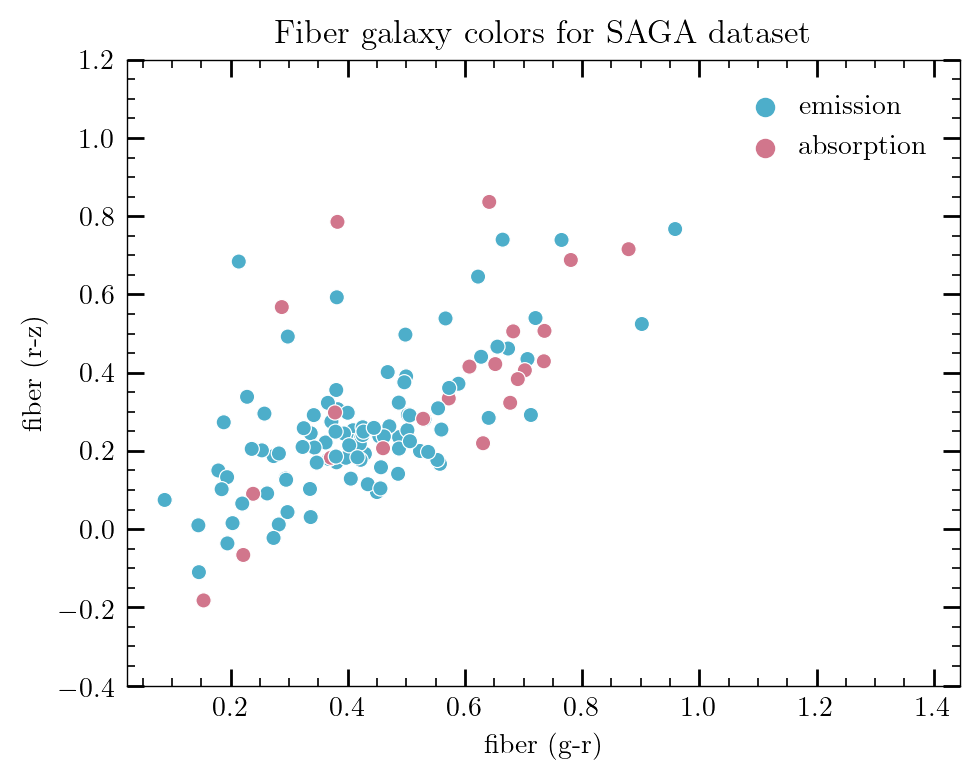

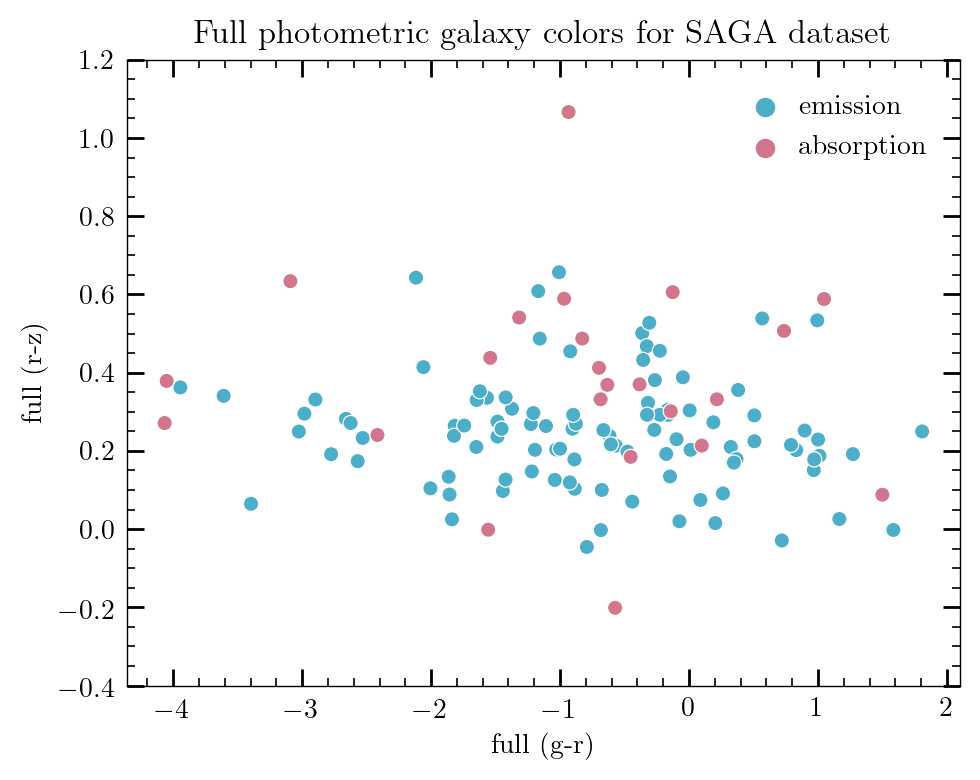

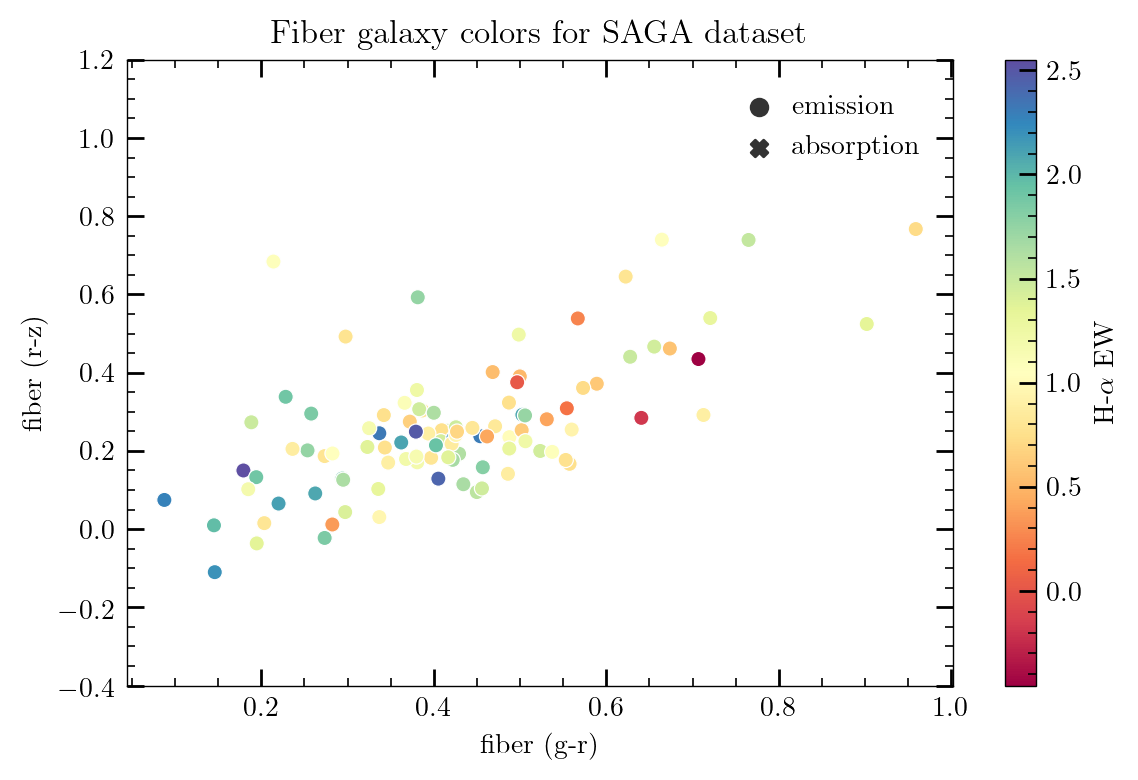

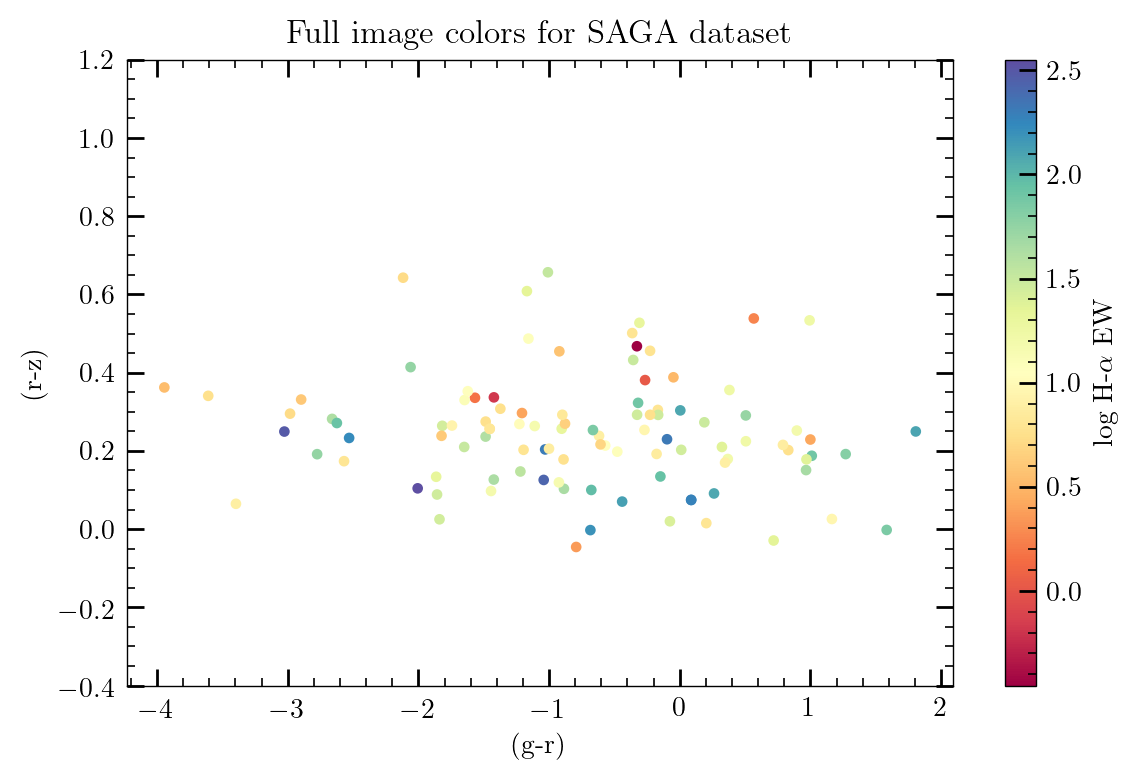

In [61]:
import seaborn as sns
# We can make some diagnostic plots, for instance this pairing of color-color plots
halpha_saga = []
halpha_sign = []
for gal in range(len(saga_df)):
    if saga_df['halpha_pos'].values[gal]==-22:
        halpha_saga.append(saga_df['halpha_neg'][gal])
        halpha_sign.append("absorption")
    else:
        halpha_saga.append(saga_df['halpha_pos'][gal])
        halpha_sign.append("emission")
fig, axes = plt.subplots(figsize=(5, 4), dpi=200)#, ncols=2)

img_scat = axes.scatter(saga_df['g_r_fiber'].values, saga_df['r_z_fiber'].values, 
                           c=halpha_saga,
                           cmap='Spectral', s=0)

sns.scatterplot(saga_df['g_r_fiber'].values, saga_df['r_z_fiber'].values,
                           cmap='Spectral', ax=axes, hue=halpha_sign, s=30)
axes.set(xlabel="fiber (g-r)", ylabel='fiber (r-z)', title="Fiber galaxy colors for SAGA dataset", 
            ylim=(-0.4, 1.2))



fig, axes = plt.subplots(figsize=(5, 4), dpi=200)#, ncols=2)

img_scat = axes.scatter(saga_df['g_r_full'].values, saga_df['r_z_full'].values, 
                           c=halpha_saga,
                           cmap='Spectral', s=0)

sns.scatterplot(saga_df['g_r_full'].values, saga_df['r_z_full'].values,
                           cmap='Spectral', ax=axes, hue=halpha_sign, s=30)
axes.set(xlabel="full (g-r)", ylabel='full (r-z)', title="Full photometric galaxy colors for SAGA dataset", 
            ylim=(-0.4, 1.2))

fig, axes = plt.subplots(figsize=(6, 4), dpi=200)#, ncols=2)

img_scat = axes.scatter(saga_df['g_r_fiber'].values, saga_df['r_z_fiber'].values, 
                           c=halpha_saga,
                           cmap='Spectral', s=0)

sns.scatterplot(saga_df['g_r_fiber'].values, saga_df['r_z_fiber'].values,
                           c=halpha_saga, marker='o',
                           cmap='Spectral', ax=axes, style=halpha_sign, s=30)
axes.set(xlabel="fiber (g-r)", ylabel='fiber (r-z)', title="Fiber galaxy colors for SAGA dataset", 
            ylim=(-0.4, 1.2))
cbar = fig.colorbar(img_scat)


fig, axes = plt.subplots(figsize=(6, 4), dpi=200)
cbar.ax.set_ylabel(r'H-$\alpha$ EW')

fiber_scat = axes.scatter(saga_df['g_r_full'].values, saga_df['r_z_full'].values,
                             c=halpha_saga, s=8,
                             cmap='Spectral')
cbar = fig.colorbar(fiber_scat, ax=axes)
axes.set(xlabel="(g-r)", ylabel='(r-z)', ylim=(-0.4, 1.2))
cbar.ax.set_ylabel(r'log H-$\alpha$ EW')
axes.set_title("Full image colors for SAGA dataset")
plt.tight_layout()

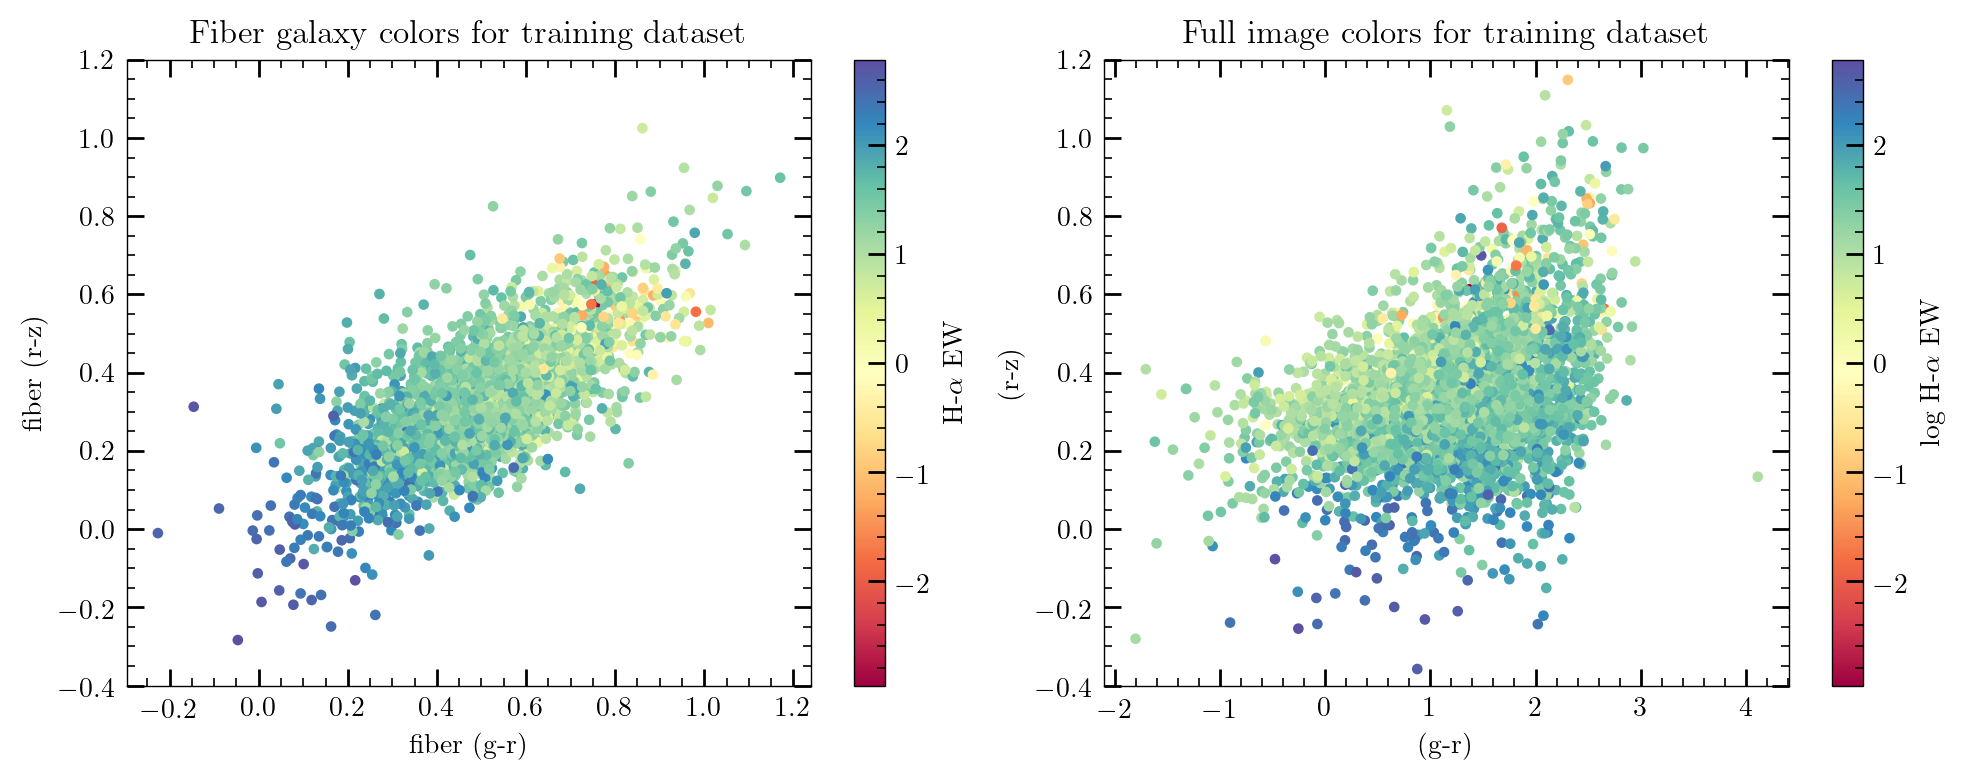

In [18]:
# We can make some diagnostic plots, for instance this pairing of color-color plots

fig, axes = plt.subplots(figsize=(10, 4), dpi=200, ncols=2)

img_scat = axes[0].scatter(cleaned_photodf['g_r_fiber'].values, cleaned_photodf['r_z_fiber'].values, s=8,
                           c=cleaned_photodf['halpha_pos'].values,
                           cmap='Spectral')

cbar = fig.colorbar(img_scat, ax=axes[0])
axes[0].set(xlabel="fiber (g-r)", ylabel='fiber (r-z)', title="Fiber galaxy colors for training dataset", 
            ylim=(-0.4, 1.2))
cbar.ax.set_ylabel(r'H-$\alpha$ EW')

fiber_scat = axes[1].scatter(cleaned_photodf['g_r_full'].values, cleaned_photodf['r_z_full'].values,
                             c=cleaned_photodf['halpha_pos'].values, s=8,
                             cmap='Spectral')
cbar = fig.colorbar(fiber_scat, ax=axes[1])
axes[1].set(xlabel="(g-r)", ylabel='(r-z)', ylim=(-0.4, 1.2))
cbar.ax.set_ylabel(r'log H-$\alpha$ EW')
axes[1].set_title("Full image colors for training dataset")
plt.tight_layout()

## Train

In [246]:
# Calculate the size of the training/testing split of the data
data_length = len(cleaned_photodf)
train_cap = int(np.floor(0.80*data_length / 50)*50)
print(train_cap)

#------Normalize the data columns------
minmaxes = {}
scaled_photodf = pd.DataFrame({})
for colname in cleaned_photodf.columns:
    minmaxes[colname] = {'min': min(cleaned_photodf[colname]), 'max': max(cleaned_photodf[colname])}
    if min(cleaned_photodf[colname])==max(cleaned_photodf[colname]):
        scaled_photodf[colname] = 0
    else:
        scaled_photodf[colname] = (cleaned_photodf[colname].values-minmaxes[colname]['min']) / (minmaxes[colname]['max'] -minmaxes[colname]['min'])

scaled_SFR = pd.DataFrame({})
for colname in ['SFR']:
    minmaxes[colname] = {'min': min(cleaned_SFR), 'max': max(cleaned_SFR)}
    scaled_SFR = (cleaned_SFR-minmaxes[colname]['min']) / (minmaxes[colname]['max'] -minmaxes[colname]['min'])
scaled_SFR = scaled_SFR.reshape(-1, 1)

3150


In [247]:
train_input = torch.Tensor(scaled_photodf.values[:train_cap])
train_ground_truth = torch.Tensor(scaled_SFR[:train_cap])
test_input = torch.Tensor(scaled_photodf.values[train_cap:])
test_ground_truth = torch.Tensor(scaled_SFR[train_cap:])

train_dataset = TensorDataset(train_input, train_ground_truth)
test_dataset = TensorDataset(test_input, test_ground_truth)
batch_size=50
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

model = FeedForwardNet()

SGD = torch.optim.Adam(model.parameters(), lr=0.0005)
SGD.zero_grad()
loss_fn = nn.MSELoss()

loss 0.17931504547595978
Evaluating results on the training dataset


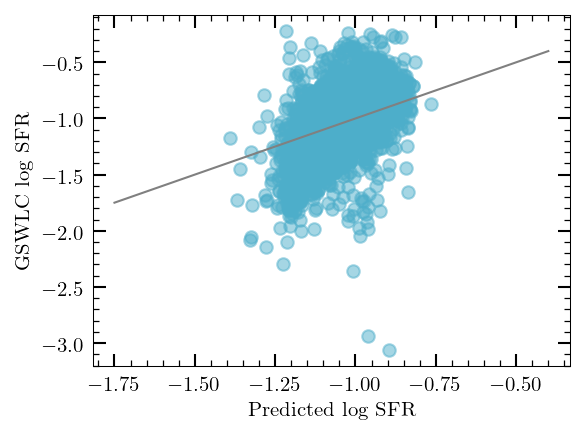

Evaluating results on the test dataset
shape '[50, 20]' is invalid for input of size 520


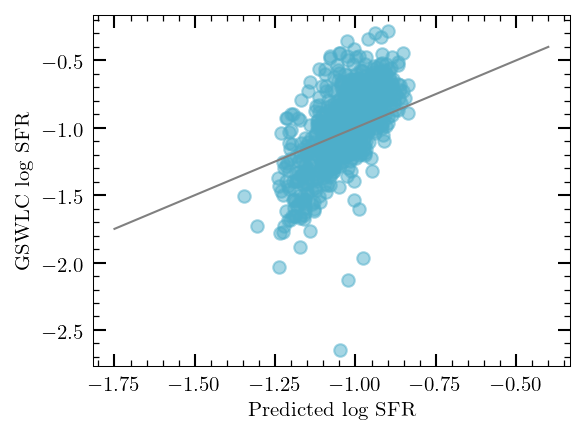

train loss tensor(0.0057)
test loss tensor(0.0074)
loss 0.17023387551307678
Evaluating results on the training dataset


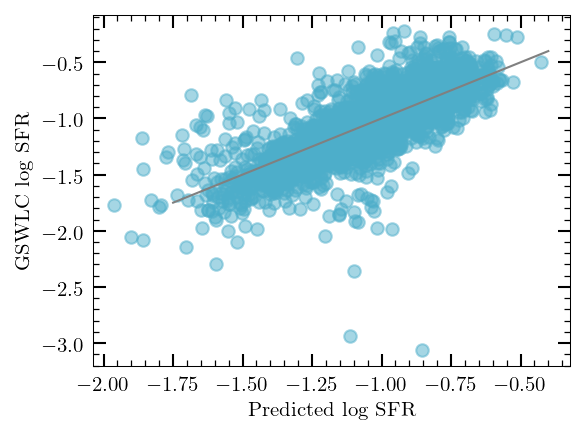

Evaluating results on the test dataset
shape '[50, 20]' is invalid for input of size 520


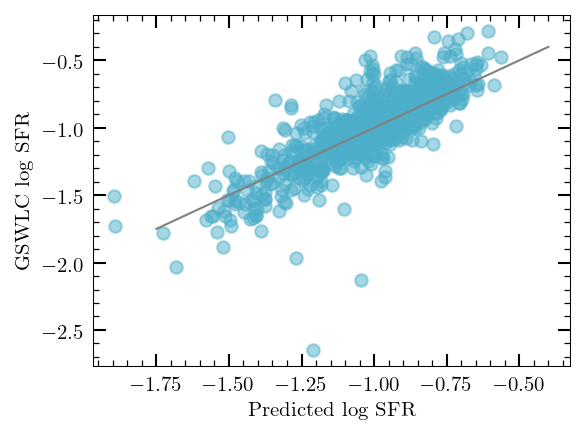

train loss tensor(0.0030)
test loss tensor(0.0017)
loss 0.16229462623596191
Evaluating results on the training dataset


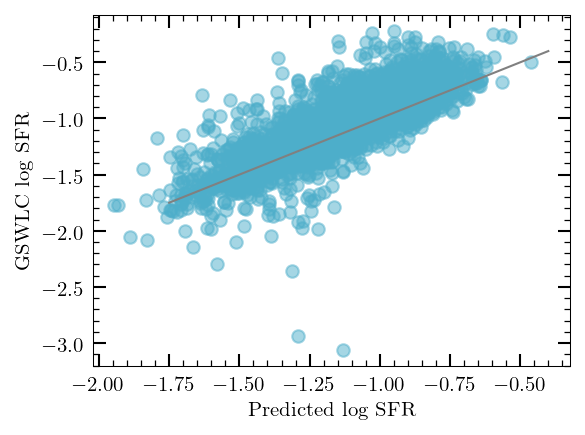

Evaluating results on the test dataset
shape '[50, 20]' is invalid for input of size 520


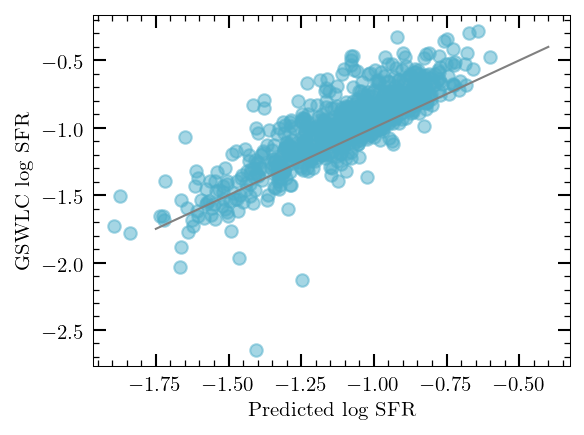

train loss tensor(0.0027)
test loss tensor(0.0045)
loss 0.15597942471504211
Evaluating results on the training dataset


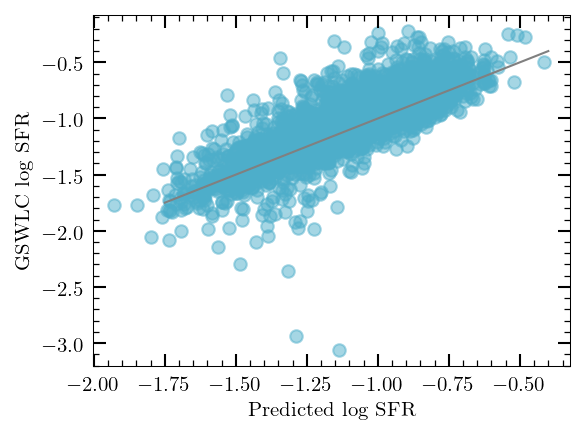

Evaluating results on the test dataset
shape '[50, 20]' is invalid for input of size 520


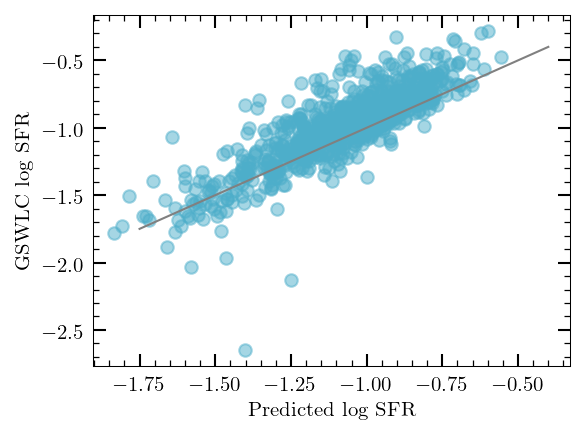

train loss tensor(0.0025)
test loss tensor(0.0038)


KeyboardInterrupt: 

In [248]:
train(model, loss_fn, SGD, train_loader, test_loader)

In [ ]:
output_almanach = np.array([])
check_collection = np.array([])
with torch.no_grad(): # this disables backpropogation, which makes the model run much more quickly.
    for data, targets in test_loader:
        try:
            model_input = torch.reshape(data, [batch_size, 20])
        except RuntimeError as e:
            continue
        output = model(model_input)
        output_almanach = np.hstack([output_almanach, output.detach().numpy().flatten()])
        check_collection = np.hstack([check_collection, targets.detach().numpy().flatten()])
fig, axes = plt.subplots(figsize=(5,5), dpi=150)
plt.hexbin( output_almanach,
            check_collection, gridsize=35)
fig, axes = plt.subplots(figsize=(6,4), dpi=150)
unscaled_output = output_almanach*(minmaxes['SFR']['max']-
                                   minmaxes['SFR']['min'])+minmaxes['SFR']['min']
unscaled_input = check_collection*(minmaxes['SFR']['max']-
                                   minmaxes['SFR']['min'])+minmaxes['SFR']['min']

scat = plt.scatter( unscaled_output,
            unscaled_input,c=cleaned_photodf['rband'].values[train_cap:725-737], cmap='Spectral_r', 
                   alpha=0.5)
cbar = plt.colorbar(scat)
cbar.ax.set_ylabel("r band")
plt.plot([-1.5, -0.5], [-1.5,  -0.5], c='grey', lw=2)
axes.set(
    xlabel='Regression log$_{10}$ SFR [$L_{\odot}$ /yr]', ylabel='GSWLC log$_{10}$ SFR [$L_{\odot}$ /yr]')


fig, axes = plt.subplots(figsize=(6,4), dpi=150)
scat = plt.scatter( unscaled_output,
            unscaled_input,c=cleaned_photodf['z'].values[train_cap:725-737], cmap='Spectral_r', 
                   alpha=0.5)
cbar = plt.colorbar(scat)
cbar.ax.set_ylabel("z")
plt.plot([-1.5,  -0.5], [-1.5,  -0.5], c='grey', lw=2)
axes.set(#xlim=(-2, 0.5), ylim=(-2, 0.5), 
    xlabel='Predicted  log$_{10}$ SFR [$L_{\odot}$ /yr]', ylabel='GSWLC log$_{10}$ SFR [$L_{\odot}$ /yr]')

# Try training on absolute magnitudes
Fitting absolute magnitudes as opposed apparent magnitudes makes no perseptible difference.

In [124]:
# Calculate the size of the training/testing split of the data
data_length = len(cleaned_absphotodf)
train_cap = int(np.floor(0.80*data_length / 50)*50)
print(train_cap)

#------Normalize the data columns------
minmaxes = {}
scaled_photodf = pd.DataFrame({})
for colname in cleaned_absphotodf.columns:
    minmaxes[colname] = {'min': min(cleaned_absphotodf[colname]), 'max': max(cleaned_absphotodf[colname])}
    if min(cleaned_absphotodf[colname])==max(cleaned_absphotodf[colname]):
        scaled_photodf[colname] = 0
    else:
        scaled_photodf[colname] = (cleaned_absphotodf[colname].values-minmaxes[colname]['min']) / (minmaxes[colname]['max'] -minmaxes[colname]['min'])

scaled_SFR = pd.DataFrame({})
for colname in ['SFR']:
    minmaxes[colname] = {'min': min(cleaned_absSFR), 'max': max(cleaned_absSFR)}
    scaled_SFR = (cleaned_SFR-minmaxes[colname]['min']) / (minmaxes[colname]['max'] -minmaxes[colname]['min'])
scaled_SFR = scaled_SFR.reshape(-1, 1)

3300


In [125]:
train_input = torch.Tensor(scaled_photodf.values[:train_cap])
train_ground_truth = torch.Tensor(scaled_absSFR[:train_cap])
test_input = torch.Tensor(scaled_photodf.values[train_cap:])
test_ground_truth = torch.Tensor(scaled_absSFR[train_cap:])

train_dataset = TensorDataset(train_input, train_ground_truth)
test_dataset = TensorDataset(test_input, test_ground_truth)
batch_size=50
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

model = FeedForwardNet()

SGD = torch.optim.Adam(model.parameters(), lr=0.0005)
SGD.zero_grad()
loss_fn = nn.MSELoss()

loss 0.14722199738025665
Evaluating results on the training dataset


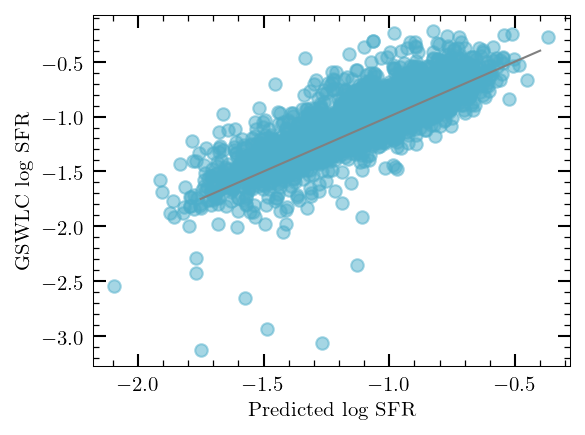

Evaluating results on the test dataset
shape '[50, 20]' is invalid for input of size 580


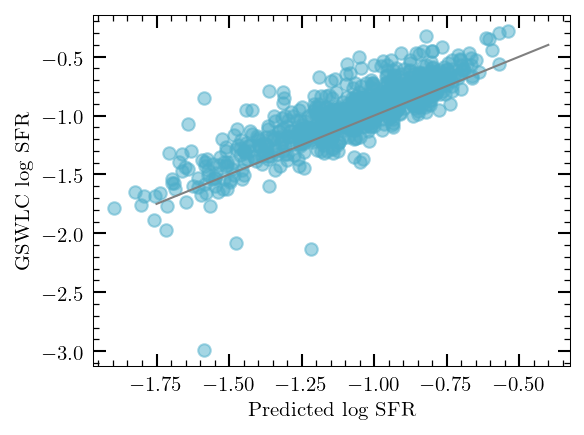

train loss tensor(0.0032)
test loss tensor(0.0043)
loss 0.14133775234222412
Evaluating results on the training dataset


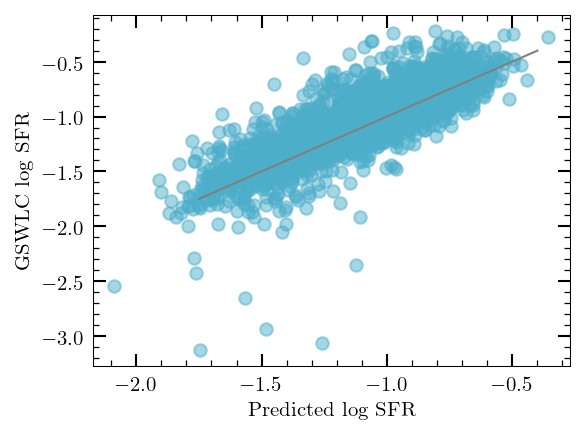

Evaluating results on the test dataset
shape '[50, 20]' is invalid for input of size 580


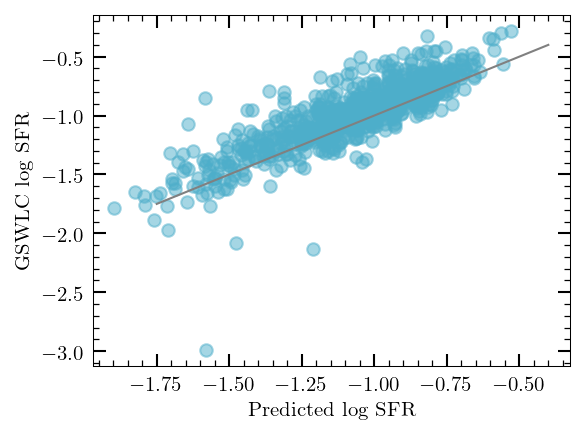

train loss tensor(0.0033)
test loss tensor(0.0032)
loss 0.1356731802225113
Evaluating results on the training dataset


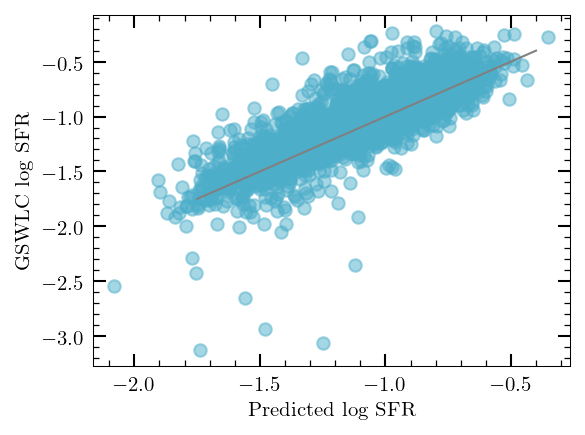

Evaluating results on the test dataset
shape '[50, 20]' is invalid for input of size 580


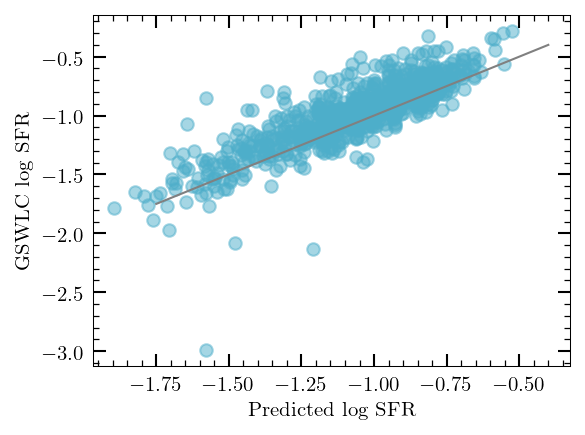

train loss tensor(0.0053)
test loss tensor(0.0032)
loss 0.13020059466362
Evaluating results on the training dataset


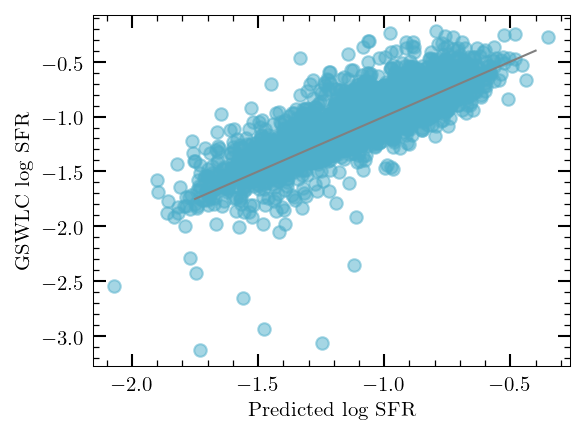

Evaluating results on the test dataset
shape '[50, 20]' is invalid for input of size 580


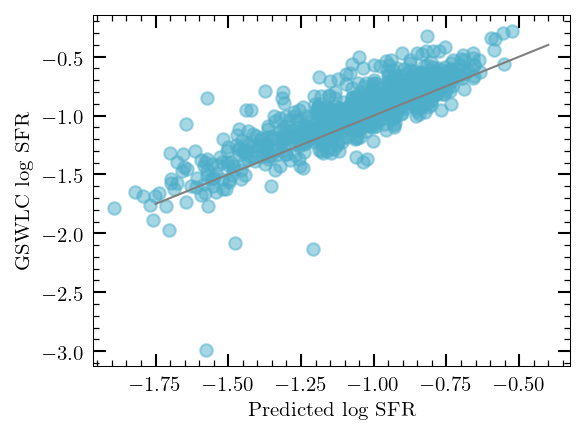

train loss tensor(0.0013)
test loss tensor(0.0017)
loss 0.12493782490491867
Evaluating results on the training dataset


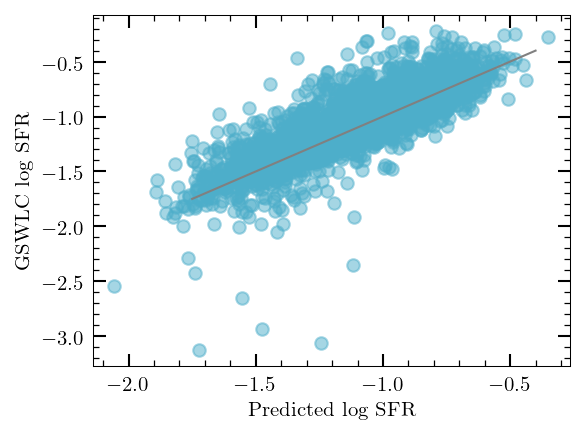

Evaluating results on the test dataset
shape '[50, 20]' is invalid for input of size 580


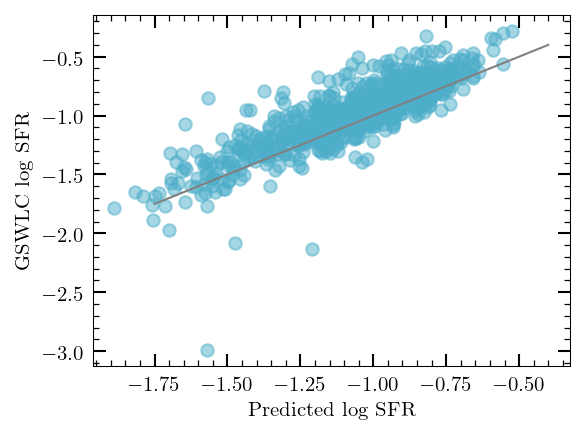

train loss tensor(0.0031)
test loss tensor(0.0032)


In [127]:
train(model, loss_fn, SGD, train_loader, test_loader)

# Apply to SAGA galaxies



In [250]:
# Normalize SAGA data to match the normalization of the trainig data

scaled_saga = pd.DataFrame({})
for colname in cleaned_photodf.columns:
    if minmaxes[colname]['min']==minmaxes[colname]['max']:
        print(colname)
        scaled_saga[colname]=0
    else:
        scaled_saga[colname] = (cleaned_sagadf[colname].values-minmaxes[colname]['min']) / (minmaxes[colname]['max'] -minmaxes[colname]['min'])

100
26
[ 0.50095814  1.5299698   0.54987895 -0.11212529 -0.11977749 -0.11653666
 -0.11617921 -0.11409785  0.5464268   0.5293233   0.5173303   0.5923789
  0.52189565  0.5284219   0.52189565  0.50475556  0.50130916  0.50014126
  0.5715632   0.53410506  0.50533086  0.5045667   0.48684078  0.51657075
  0.5533073   0.5284219 ]
126
126
126


[Text(0, 0.5, 'log$_{10}$ SFR [$L_{\\odot}$ /yr]'),
 (0.0, 3.0),
 Text(0.5, 0, 'H-$\\alpha$ EW')]

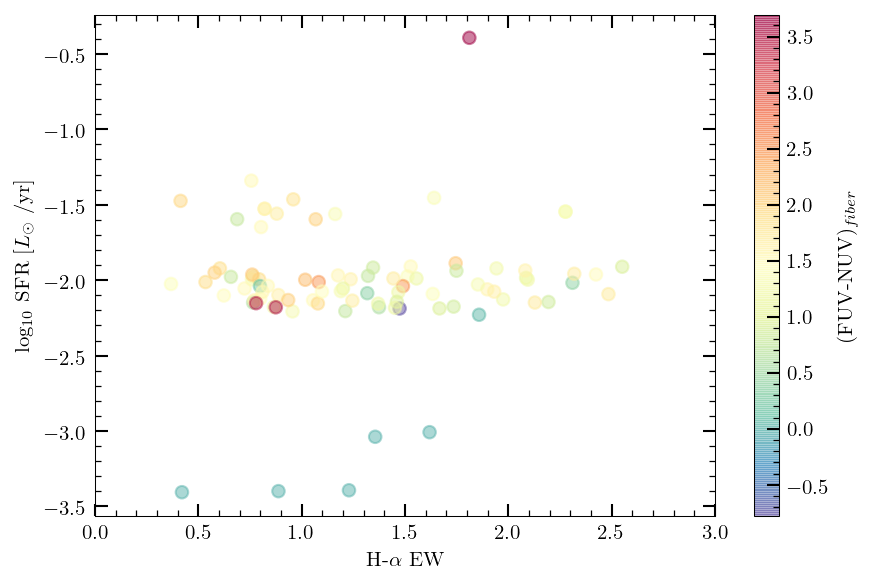

In [264]:
output_almanach = np.array([])

#run the model on the core of the dataset
core_data_size = int(np.floor(len(scaled_saga.values)/batch_size))*batch_size
print(core_data_size)
saga = torch.Tensor(scaled_saga.values[:core_data_size])
saga_dataset = TensorDataset(saga)

saga_loader = torch.utils.data.DataLoader(saga_dataset, batch_size=batch_size)

with torch.no_grad(): # this disables backpropogation, which makes the model run much more quickly.
    for data, in saga_loader:
        model_input = torch.reshape(data, [batch_size, 20])
        output = model(model_input)
        output_almanach = np.hstack([output_almanach, output.detach().numpy().flatten()])

        
# Now run the model on the last part of the data, 
# to account for the fact that data size % batch size is not zero:

saga_remainder = torch.Tensor(scaled_saga.values[-batch_size:])
saga_remainder = TensorDataset(saga_remainder)
saga_remainder_loader = torch.utils.data.DataLoader(saga_remainder, batch_size=batch_size)
number_to_keep = len(scaled_saga.values) % batch_size
print(number_to_keep)
with torch.no_grad(): # this disables backpropogation, which makes the model run much more quickly.
    for data, in saga_remainder_loader:
        model_input = torch.reshape(data, [batch_size, 20])
        output = model(model_input)
        last_output_left = output.detach().numpy().flatten()[-number_to_keep:]
        print(last_output_left)
        output_almanach = np.hstack([output_almanach, last_output_left])

print(len(output_almanach))
descaled_SFR = output_almanach*(minmaxes['SFR']['max']-
                                   minmaxes['SFR']['min'])+minmaxes['SFR']['min']

mask_no_uv = np.where(cleaned_sagadf['fuv_nuv_fiber']<100)[0]
print(len(descaled_SFR))
print(len(saga_df['halpha_pos']))
fig, axes = plt.subplots(figsize=(6,4), dpi=150)
scat = plt.scatter( cleaned_sagadf['halpha_pos'][mask_no_uv],
            descaled_SFR[mask_no_uv], cmap='Spectral_r', c=cleaned_sagadf['fuv_nuv_fiber'][mask_no_uv],
                   alpha=0.5)
cbar = plt.colorbar(scat)
cbar.ax.set_ylabel("(FUV-NUV)$_{fiber}$")
axes.set(xlim=(0, 3), 
    xlabel=r'H-$\alpha$ EW', ylabel='log$_{10}$ SFR [$L_{\odot}$ /yr]')

In [270]:
mask_no_uv = cleaned_sagadf['fuv_nuv_fiber']<100

In [278]:
import pandas as pd

In [276]:
df = pd.DataFrame({'SFR': descaled_SFR,
                   'SAGA index': range(len(saga_df)),
                   'Has Legacy Survey UV': mask_no_uv})

df.to_csv("SAGA_SFR.txt",index=False)